In [14]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm 

In [ ]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)


# 1.Encoder and Decoder classes


In [4]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

# 2. Model, optimizer, loss

In [5]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

# 3. Training

In [6]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [7]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [8]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 0.253088
	 partial train loss (single batch): 0.246307
	 partial train loss (single batch): 0.240699
	 partial train loss (single batch): 0.235872
	 partial train loss (single batch): 0.231858
	 partial train loss (single batch): 0.228480
	 partial train loss (single batch): 0.224729
	 partial train loss (single batch): 0.221779
	 partial train loss (single batch): 0.219602
	 partial train loss (single batch): 0.217715
	 partial train loss (single batch): 0.215554
	 partial train loss (single batch): 0.213383
	 partial train loss (single batch): 0.211351
	 partial train loss (single batch): 0.209110
	 partial train loss (single batch): 0.207140
	 partial train loss (single batch): 0.204835
	 partial train loss (single batch): 0.202851
	 partial train loss (single batch): 0.201437
	 partial train loss (single batch): 0.199003
	 partial train loss (single batch): 0.197170
	 partial train loss (single batch): 0.195566
	 partial train loss (single batch

	 partial train loss (single batch): 0.068363
	 partial train loss (single batch): 0.067906
	 partial train loss (single batch): 0.066897
	 partial train loss (single batch): 0.067073
	 partial train loss (single batch): 0.067040
	 partial train loss (single batch): 0.067681
	 partial train loss (single batch): 0.067067
	 partial train loss (single batch): 0.067323
	 partial train loss (single batch): 0.066034

 EPOCH 1/30 	 train loss 0.12252073734998703 	 val loss 0.06530794501304626


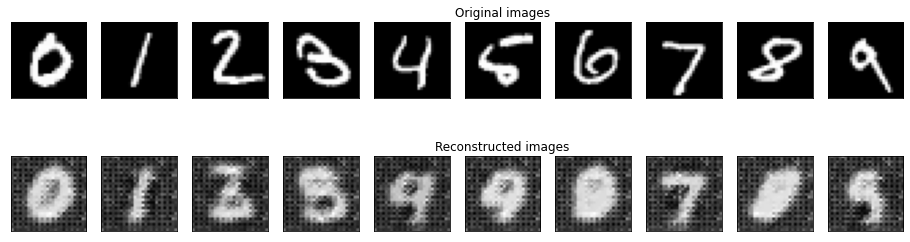

	 partial train loss (single batch): 0.067281
	 partial train loss (single batch): 0.066273
	 partial train loss (single batch): 0.065977
	 partial train loss (single batch): 0.065715
	 partial train loss (single batch): 0.065319
	 partial train loss (single batch): 0.065413
	 partial train loss (single batch): 0.065568
	 partial train loss (single batch): 0.065224
	 partial train loss (single batch): 0.065204
	 partial train loss (single batch): 0.063561
	 partial train loss (single batch): 0.063390
	 partial train loss (single batch): 0.063198
	 partial train loss (single batch): 0.063331
	 partial train loss (single batch): 0.063002
	 partial train loss (single batch): 0.064076
	 partial train loss (single batch): 0.063112
	 partial train loss (single batch): 0.062517
	 partial train loss (single batch): 0.061937
	 partial train loss (single batch): 0.062299
	 partial train loss (single batch): 0.062357
	 partial train loss (single batch): 0.061263
	 partial train loss (single batch

	 partial train loss (single batch): 0.047052
	 partial train loss (single batch): 0.045904
	 partial train loss (single batch): 0.045894
	 partial train loss (single batch): 0.046166
	 partial train loss (single batch): 0.047344
	 partial train loss (single batch): 0.046369
	 partial train loss (single batch): 0.047089
	 partial train loss (single batch): 0.046167

 EPOCH 2/30 	 train loss 0.05388312041759491 	 val loss 0.04685145989060402


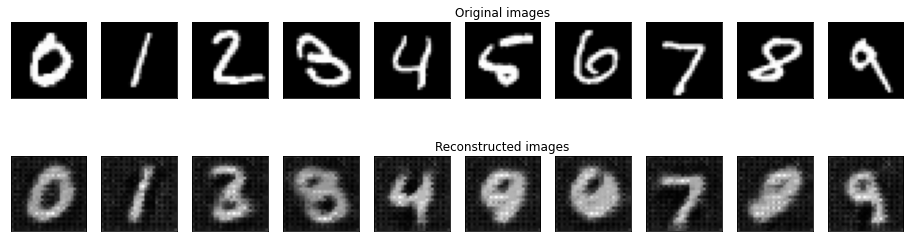

	 partial train loss (single batch): 0.048534
	 partial train loss (single batch): 0.047152
	 partial train loss (single batch): 0.046636
	 partial train loss (single batch): 0.046451
	 partial train loss (single batch): 0.046186
	 partial train loss (single batch): 0.046448
	 partial train loss (single batch): 0.047453
	 partial train loss (single batch): 0.046752
	 partial train loss (single batch): 0.046919
	 partial train loss (single batch): 0.045656
	 partial train loss (single batch): 0.044751
	 partial train loss (single batch): 0.045468
	 partial train loss (single batch): 0.045617
	 partial train loss (single batch): 0.045272
	 partial train loss (single batch): 0.046501
	 partial train loss (single batch): 0.045586
	 partial train loss (single batch): 0.045126
	 partial train loss (single batch): 0.044792
	 partial train loss (single batch): 0.045737
	 partial train loss (single batch): 0.045519
	 partial train loss (single batch): 0.044438
	 partial train loss (single batch

	 partial train loss (single batch): 0.037241
	 partial train loss (single batch): 0.036922
	 partial train loss (single batch): 0.037217
	 partial train loss (single batch): 0.038449
	 partial train loss (single batch): 0.037312
	 partial train loss (single batch): 0.038398
	 partial train loss (single batch): 0.037682

 EPOCH 3/30 	 train loss 0.04163055866956711 	 val loss 0.03761491924524307


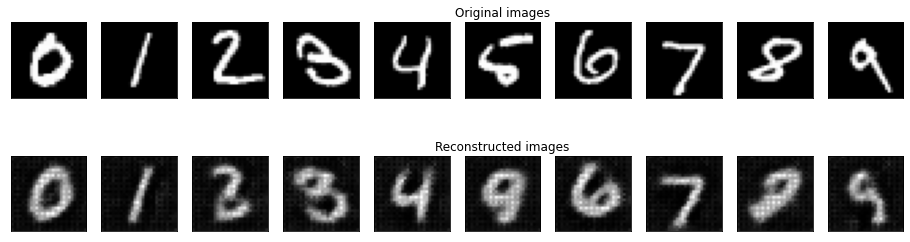

	 partial train loss (single batch): 0.040399
	 partial train loss (single batch): 0.038127
	 partial train loss (single batch): 0.038003
	 partial train loss (single batch): 0.037662
	 partial train loss (single batch): 0.037593
	 partial train loss (single batch): 0.037455
	 partial train loss (single batch): 0.038518
	 partial train loss (single batch): 0.038111
	 partial train loss (single batch): 0.037951
	 partial train loss (single batch): 0.037160
	 partial train loss (single batch): 0.035763
	 partial train loss (single batch): 0.036968
	 partial train loss (single batch): 0.037283
	 partial train loss (single batch): 0.037087
	 partial train loss (single batch): 0.038059
	 partial train loss (single batch): 0.036766
	 partial train loss (single batch): 0.036992
	 partial train loss (single batch): 0.036430
	 partial train loss (single batch): 0.037523
	 partial train loss (single batch): 0.037487
	 partial train loss (single batch): 0.036613
	 partial train loss (single batch

	 partial train loss (single batch): 0.033967
	 partial train loss (single batch): 0.033060
	 partial train loss (single batch): 0.032700
	 partial train loss (single batch): 0.032902
	 partial train loss (single batch): 0.033946
	 partial train loss (single batch): 0.032677
	 partial train loss (single batch): 0.034289
	 partial train loss (single batch): 0.033380

 EPOCH 4/30 	 train loss 0.03501991555094719 	 val loss 0.033222001045942307


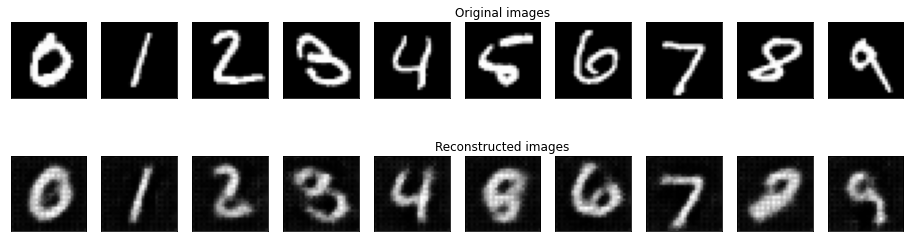

	 partial train loss (single batch): 0.036695
	 partial train loss (single batch): 0.033654
	 partial train loss (single batch): 0.033811
	 partial train loss (single batch): 0.033550
	 partial train loss (single batch): 0.033598
	 partial train loss (single batch): 0.033104
	 partial train loss (single batch): 0.034316
	 partial train loss (single batch): 0.034065
	 partial train loss (single batch): 0.033586
	 partial train loss (single batch): 0.033052
	 partial train loss (single batch): 0.032029
	 partial train loss (single batch): 0.032753
	 partial train loss (single batch): 0.033566
	 partial train loss (single batch): 0.033448
	 partial train loss (single batch): 0.034163
	 partial train loss (single batch): 0.032838
	 partial train loss (single batch): 0.033306
	 partial train loss (single batch): 0.032584
	 partial train loss (single batch): 0.033773
	 partial train loss (single batch): 0.033759
	 partial train loss (single batch): 0.033143
	 partial train loss (single batch

	 partial train loss (single batch): 0.032099
	 partial train loss (single batch): 0.031227
	 partial train loss (single batch): 0.030748
	 partial train loss (single batch): 0.030795
	 partial train loss (single batch): 0.031950
	 partial train loss (single batch): 0.030482
	 partial train loss (single batch): 0.032386
	 partial train loss (single batch): 0.031272

 EPOCH 5/30 	 train loss 0.032083820551633835 	 val loss 0.031191019341349602


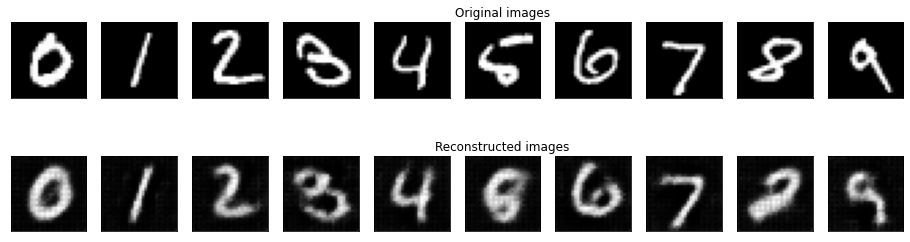

	 partial train loss (single batch): 0.034716
	 partial train loss (single batch): 0.031539
	 partial train loss (single batch): 0.032012
	 partial train loss (single batch): 0.031403
	 partial train loss (single batch): 0.031568
	 partial train loss (single batch): 0.031040
	 partial train loss (single batch): 0.032290
	 partial train loss (single batch): 0.032095
	 partial train loss (single batch): 0.031579
	 partial train loss (single batch): 0.031052
	 partial train loss (single batch): 0.030070
	 partial train loss (single batch): 0.030728
	 partial train loss (single batch): 0.031536
	 partial train loss (single batch): 0.031631
	 partial train loss (single batch): 0.032463
	 partial train loss (single batch): 0.030887
	 partial train loss (single batch): 0.031366
	 partial train loss (single batch): 0.030454
	 partial train loss (single batch): 0.031893
	 partial train loss (single batch): 0.032015
	 partial train loss (single batch): 0.031520
	 partial train loss (single batch

	 partial train loss (single batch): 0.029929
	 partial train loss (single batch): 0.030902
	 partial train loss (single batch): 0.030087
	 partial train loss (single batch): 0.029627
	 partial train loss (single batch): 0.029668
	 partial train loss (single batch): 0.030816
	 partial train loss (single batch): 0.029165
	 partial train loss (single batch): 0.030919
	 partial train loss (single batch): 0.029798

 EPOCH 6/30 	 train loss 0.030555296689271927 	 val loss 0.03017984703183174


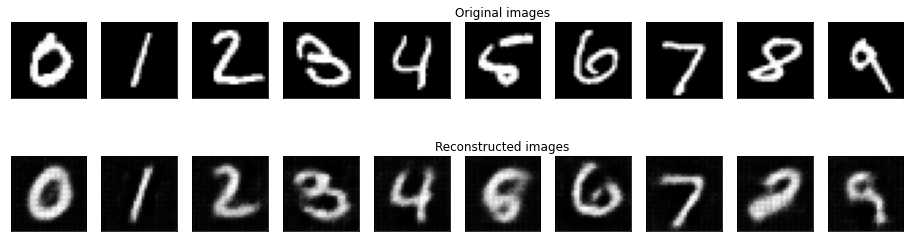

	 partial train loss (single batch): 0.033447
	 partial train loss (single batch): 0.030323
	 partial train loss (single batch): 0.030787
	 partial train loss (single batch): 0.030309
	 partial train loss (single batch): 0.030371
	 partial train loss (single batch): 0.029716
	 partial train loss (single batch): 0.031066
	 partial train loss (single batch): 0.030885
	 partial train loss (single batch): 0.030456
	 partial train loss (single batch): 0.029916
	 partial train loss (single batch): 0.028977
	 partial train loss (single batch): 0.029550
	 partial train loss (single batch): 0.030491
	 partial train loss (single batch): 0.030376
	 partial train loss (single batch): 0.031337
	 partial train loss (single batch): 0.029817
	 partial train loss (single batch): 0.030139
	 partial train loss (single batch): 0.029359
	 partial train loss (single batch): 0.030947
	 partial train loss (single batch): 0.030879
	 partial train loss (single batch): 0.030553
	 partial train loss (single batch

	 partial train loss (single batch): 0.029336
	 partial train loss (single batch): 0.030132
	 partial train loss (single batch): 0.029325
	 partial train loss (single batch): 0.028916
	 partial train loss (single batch): 0.029081
	 partial train loss (single batch): 0.030047
	 partial train loss (single batch): 0.028343
	 partial train loss (single batch): 0.030012
	 partial train loss (single batch): 0.028841

 EPOCH 7/30 	 train loss 0.02961670607328415 	 val loss 0.029492821544408798


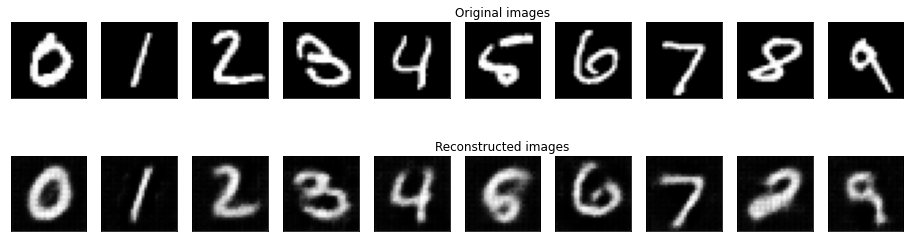

	 partial train loss (single batch): 0.032780
	 partial train loss (single batch): 0.029533
	 partial train loss (single batch): 0.030080
	 partial train loss (single batch): 0.029468
	 partial train loss (single batch): 0.029629
	 partial train loss (single batch): 0.028988
	 partial train loss (single batch): 0.030289
	 partial train loss (single batch): 0.030142
	 partial train loss (single batch): 0.029793
	 partial train loss (single batch): 0.029234
	 partial train loss (single batch): 0.028244
	 partial train loss (single batch): 0.028911
	 partial train loss (single batch): 0.029691
	 partial train loss (single batch): 0.029593
	 partial train loss (single batch): 0.030602
	 partial train loss (single batch): 0.029136
	 partial train loss (single batch): 0.029484
	 partial train loss (single batch): 0.028431
	 partial train loss (single batch): 0.030343
	 partial train loss (single batch): 0.030043
	 partial train loss (single batch): 0.029655
	 partial train loss (single batch

	 partial train loss (single batch): 0.028684
	 partial train loss (single batch): 0.028220
	 partial train loss (single batch): 0.028511
	 partial train loss (single batch): 0.029507
	 partial train loss (single batch): 0.027673
	 partial train loss (single batch): 0.029276
	 partial train loss (single batch): 0.028171

 EPOCH 8/30 	 train loss 0.028935762122273445 	 val loss 0.028913438320159912


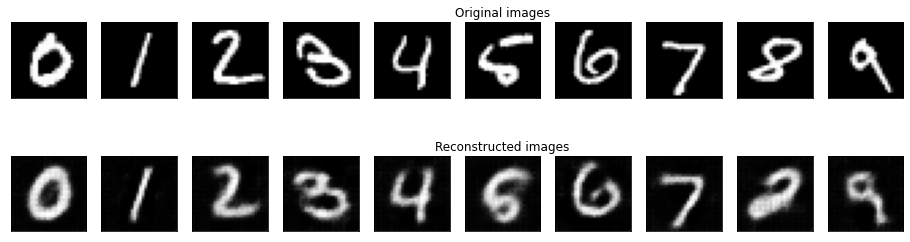

	 partial train loss (single batch): 0.032206
	 partial train loss (single batch): 0.028909
	 partial train loss (single batch): 0.029677
	 partial train loss (single batch): 0.028834
	 partial train loss (single batch): 0.029215
	 partial train loss (single batch): 0.028422
	 partial train loss (single batch): 0.029626
	 partial train loss (single batch): 0.029566
	 partial train loss (single batch): 0.029158
	 partial train loss (single batch): 0.028786
	 partial train loss (single batch): 0.027576
	 partial train loss (single batch): 0.028364
	 partial train loss (single batch): 0.029149
	 partial train loss (single batch): 0.028950
	 partial train loss (single batch): 0.029867
	 partial train loss (single batch): 0.028604
	 partial train loss (single batch): 0.028806
	 partial train loss (single batch): 0.027720
	 partial train loss (single batch): 0.029799
	 partial train loss (single batch): 0.029379
	 partial train loss (single batch): 0.029060
	 partial train loss (single batch

	 partial train loss (single batch): 0.028085
	 partial train loss (single batch): 0.027705
	 partial train loss (single batch): 0.028092
	 partial train loss (single batch): 0.029009
	 partial train loss (single batch): 0.027256
	 partial train loss (single batch): 0.028715
	 partial train loss (single batch): 0.027521

 EPOCH 9/30 	 train loss 0.02844180539250374 	 val loss 0.0285046324133873


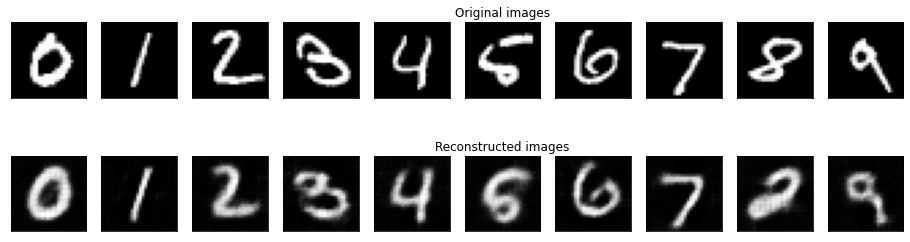

	 partial train loss (single batch): 0.031818
	 partial train loss (single batch): 0.028481
	 partial train loss (single batch): 0.029171
	 partial train loss (single batch): 0.028344
	 partial train loss (single batch): 0.028744
	 partial train loss (single batch): 0.028049
	 partial train loss (single batch): 0.029141
	 partial train loss (single batch): 0.029156
	 partial train loss (single batch): 0.028804
	 partial train loss (single batch): 0.028396
	 partial train loss (single batch): 0.027149
	 partial train loss (single batch): 0.027913
	 partial train loss (single batch): 0.028769
	 partial train loss (single batch): 0.028528
	 partial train loss (single batch): 0.029418
	 partial train loss (single batch): 0.028188
	 partial train loss (single batch): 0.028373
	 partial train loss (single batch): 0.027309
	 partial train loss (single batch): 0.029339
	 partial train loss (single batch): 0.028932
	 partial train loss (single batch): 0.028625
	 partial train loss (single batch

	 partial train loss (single batch): 0.027907
	 partial train loss (single batch): 0.028777
	 partial train loss (single batch): 0.027804
	 partial train loss (single batch): 0.027267
	 partial train loss (single batch): 0.027738
	 partial train loss (single batch): 0.028734
	 partial train loss (single batch): 0.027039
	 partial train loss (single batch): 0.028339
	 partial train loss (single batch): 0.027159

 EPOCH 10/30 	 train loss 0.028028609231114388 	 val loss 0.02825981378555298


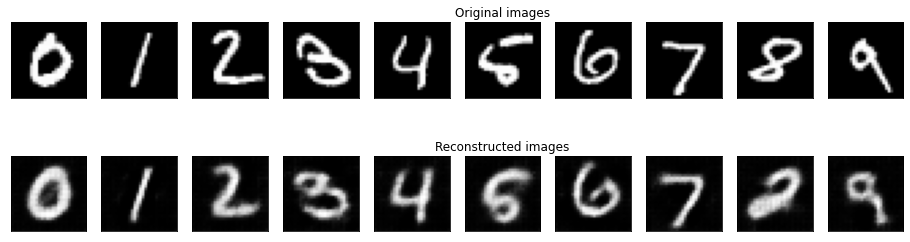

	 partial train loss (single batch): 0.031461
	 partial train loss (single batch): 0.028156
	 partial train loss (single batch): 0.028908
	 partial train loss (single batch): 0.028086
	 partial train loss (single batch): 0.028440
	 partial train loss (single batch): 0.027698
	 partial train loss (single batch): 0.028885
	 partial train loss (single batch): 0.028829
	 partial train loss (single batch): 0.028462
	 partial train loss (single batch): 0.028105
	 partial train loss (single batch): 0.026811
	 partial train loss (single batch): 0.027580
	 partial train loss (single batch): 0.028511
	 partial train loss (single batch): 0.028295
	 partial train loss (single batch): 0.029108
	 partial train loss (single batch): 0.027904
	 partial train loss (single batch): 0.028022
	 partial train loss (single batch): 0.027011
	 partial train loss (single batch): 0.029019
	 partial train loss (single batch): 0.028572
	 partial train loss (single batch): 0.028325
	 partial train loss (single batch

	 partial train loss (single batch): 0.027437
	 partial train loss (single batch): 0.026873
	 partial train loss (single batch): 0.027394
	 partial train loss (single batch): 0.028510
	 partial train loss (single batch): 0.026790
	 partial train loss (single batch): 0.028031
	 partial train loss (single batch): 0.026769

 EPOCH 11/30 	 train loss 0.027705397456884384 	 val loss 0.02796274423599243


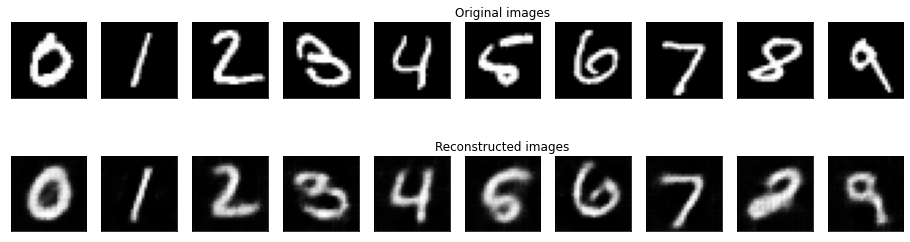

	 partial train loss (single batch): 0.031086
	 partial train loss (single batch): 0.027877
	 partial train loss (single batch): 0.028563
	 partial train loss (single batch): 0.027786
	 partial train loss (single batch): 0.028095
	 partial train loss (single batch): 0.027444
	 partial train loss (single batch): 0.028513
	 partial train loss (single batch): 0.028498
	 partial train loss (single batch): 0.028286
	 partial train loss (single batch): 0.027816
	 partial train loss (single batch): 0.026556
	 partial train loss (single batch): 0.027275
	 partial train loss (single batch): 0.028102
	 partial train loss (single batch): 0.027831
	 partial train loss (single batch): 0.028795
	 partial train loss (single batch): 0.027602
	 partial train loss (single batch): 0.027624
	 partial train loss (single batch): 0.026609
	 partial train loss (single batch): 0.028704
	 partial train loss (single batch): 0.028213
	 partial train loss (single batch): 0.028044
	 partial train loss (single batch

	 partial train loss (single batch): 0.027303
	 partial train loss (single batch): 0.028400
	 partial train loss (single batch): 0.027167
	 partial train loss (single batch): 0.026621
	 partial train loss (single batch): 0.027174
	 partial train loss (single batch): 0.028202
	 partial train loss (single batch): 0.026643
	 partial train loss (single batch): 0.027737
	 partial train loss (single batch): 0.026523

 EPOCH 12/30 	 train loss 0.02741626277565956 	 val loss 0.027654288336634636


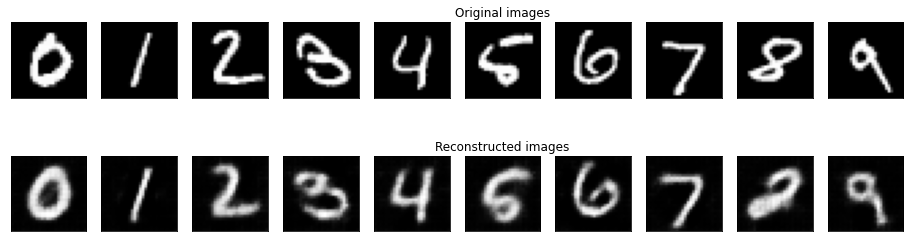

	 partial train loss (single batch): 0.030671
	 partial train loss (single batch): 0.027623
	 partial train loss (single batch): 0.028302
	 partial train loss (single batch): 0.027481
	 partial train loss (single batch): 0.027755
	 partial train loss (single batch): 0.027180
	 partial train loss (single batch): 0.028282
	 partial train loss (single batch): 0.028233
	 partial train loss (single batch): 0.028048
	 partial train loss (single batch): 0.027474
	 partial train loss (single batch): 0.026389
	 partial train loss (single batch): 0.027013
	 partial train loss (single batch): 0.027813
	 partial train loss (single batch): 0.027553
	 partial train loss (single batch): 0.028520
	 partial train loss (single batch): 0.027306
	 partial train loss (single batch): 0.027324
	 partial train loss (single batch): 0.026328
	 partial train loss (single batch): 0.028337
	 partial train loss (single batch): 0.027936
	 partial train loss (single batch): 0.027824
	 partial train loss (single batch

	 partial train loss (single batch): 0.027145
	 partial train loss (single batch): 0.028283
	 partial train loss (single batch): 0.026948
	 partial train loss (single batch): 0.026391
	 partial train loss (single batch): 0.026924
	 partial train loss (single batch): 0.027946
	 partial train loss (single batch): 0.026435
	 partial train loss (single batch): 0.027489
	 partial train loss (single batch): 0.026171

 EPOCH 13/30 	 train loss 0.027163062244653702 	 val loss 0.027440469712018967


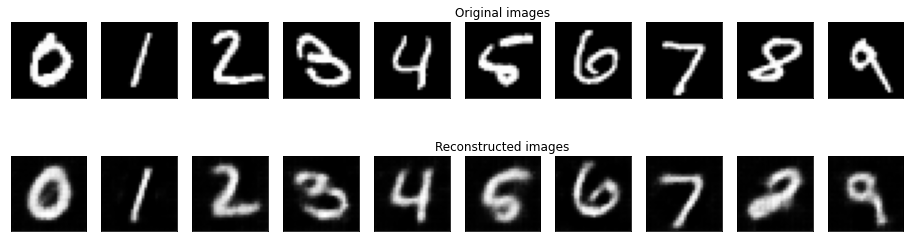

	 partial train loss (single batch): 0.030379
	 partial train loss (single batch): 0.027394
	 partial train loss (single batch): 0.028074
	 partial train loss (single batch): 0.027316
	 partial train loss (single batch): 0.027469
	 partial train loss (single batch): 0.027010
	 partial train loss (single batch): 0.028108
	 partial train loss (single batch): 0.028015
	 partial train loss (single batch): 0.027831
	 partial train loss (single batch): 0.027318
	 partial train loss (single batch): 0.026233
	 partial train loss (single batch): 0.026896
	 partial train loss (single batch): 0.027631
	 partial train loss (single batch): 0.027387
	 partial train loss (single batch): 0.028268
	 partial train loss (single batch): 0.027070
	 partial train loss (single batch): 0.027066
	 partial train loss (single batch): 0.026140
	 partial train loss (single batch): 0.028085
	 partial train loss (single batch): 0.027736
	 partial train loss (single batch): 0.027672
	 partial train loss (single batch

	 partial train loss (single batch): 0.026948
	 partial train loss (single batch): 0.028095
	 partial train loss (single batch): 0.026725
	 partial train loss (single batch): 0.026213
	 partial train loss (single batch): 0.026591
	 partial train loss (single batch): 0.027722
	 partial train loss (single batch): 0.026287
	 partial train loss (single batch): 0.027433
	 partial train loss (single batch): 0.025927

 EPOCH 14/30 	 train loss 0.026944320648908615 	 val loss 0.02722662314772606


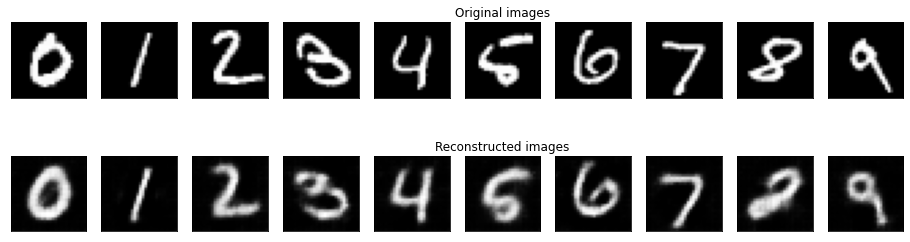

	 partial train loss (single batch): 0.030114
	 partial train loss (single batch): 0.027232
	 partial train loss (single batch): 0.027782
	 partial train loss (single batch): 0.027037
	 partial train loss (single batch): 0.027262
	 partial train loss (single batch): 0.026837
	 partial train loss (single batch): 0.027903
	 partial train loss (single batch): 0.027807
	 partial train loss (single batch): 0.027615
	 partial train loss (single batch): 0.027090
	 partial train loss (single batch): 0.026025
	 partial train loss (single batch): 0.026742
	 partial train loss (single batch): 0.027347
	 partial train loss (single batch): 0.027073
	 partial train loss (single batch): 0.028082
	 partial train loss (single batch): 0.026907
	 partial train loss (single batch): 0.026761
	 partial train loss (single batch): 0.025937
	 partial train loss (single batch): 0.027800
	 partial train loss (single batch): 0.027528
	 partial train loss (single batch): 0.027565
	 partial train loss (single batch

	 partial train loss (single batch): 0.027999
	 partial train loss (single batch): 0.026656
	 partial train loss (single batch): 0.026088
	 partial train loss (single batch): 0.026388
	 partial train loss (single batch): 0.027533
	 partial train loss (single batch): 0.026110
	 partial train loss (single batch): 0.027261
	 partial train loss (single batch): 0.025689

 EPOCH 15/30 	 train loss 0.02675040252506733 	 val loss 0.027005711570382118


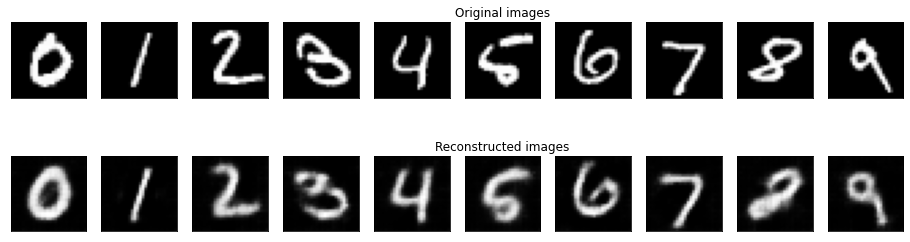

	 partial train loss (single batch): 0.029874
	 partial train loss (single batch): 0.027108
	 partial train loss (single batch): 0.027643
	 partial train loss (single batch): 0.026900
	 partial train loss (single batch): 0.027114
	 partial train loss (single batch): 0.026702
	 partial train loss (single batch): 0.027760
	 partial train loss (single batch): 0.027724
	 partial train loss (single batch): 0.027455
	 partial train loss (single batch): 0.026976
	 partial train loss (single batch): 0.025952
	 partial train loss (single batch): 0.026573
	 partial train loss (single batch): 0.027300
	 partial train loss (single batch): 0.026839
	 partial train loss (single batch): 0.027868
	 partial train loss (single batch): 0.026714
	 partial train loss (single batch): 0.026586
	 partial train loss (single batch): 0.025729
	 partial train loss (single batch): 0.027634
	 partial train loss (single batch): 0.027379
	 partial train loss (single batch): 0.027401
	 partial train loss (single batch

	 partial train loss (single batch): 0.026637
	 partial train loss (single batch): 0.027907
	 partial train loss (single batch): 0.026480
	 partial train loss (single batch): 0.025900
	 partial train loss (single batch): 0.026250
	 partial train loss (single batch): 0.027340
	 partial train loss (single batch): 0.025920
	 partial train loss (single batch): 0.027155
	 partial train loss (single batch): 0.025515

 EPOCH 16/30 	 train loss 0.026579098775982857 	 val loss 0.02686757594347


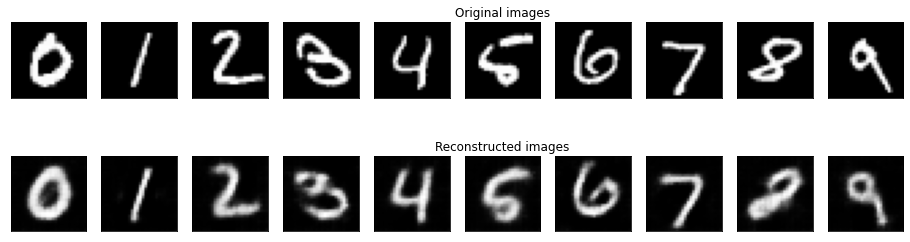

	 partial train loss (single batch): 0.029693
	 partial train loss (single batch): 0.026919
	 partial train loss (single batch): 0.027454
	 partial train loss (single batch): 0.026725
	 partial train loss (single batch): 0.026952
	 partial train loss (single batch): 0.026577
	 partial train loss (single batch): 0.027539
	 partial train loss (single batch): 0.027525
	 partial train loss (single batch): 0.027294
	 partial train loss (single batch): 0.026849
	 partial train loss (single batch): 0.025771
	 partial train loss (single batch): 0.026401
	 partial train loss (single batch): 0.027048
	 partial train loss (single batch): 0.026696
	 partial train loss (single batch): 0.027654
	 partial train loss (single batch): 0.026550
	 partial train loss (single batch): 0.026442
	 partial train loss (single batch): 0.025628
	 partial train loss (single batch): 0.027457
	 partial train loss (single batch): 0.027182
	 partial train loss (single batch): 0.027278
	 partial train loss (single batch

	 partial train loss (single batch): 0.027737
	 partial train loss (single batch): 0.026343
	 partial train loss (single batch): 0.025717
	 partial train loss (single batch): 0.026139
	 partial train loss (single batch): 0.027232
	 partial train loss (single batch): 0.025795
	 partial train loss (single batch): 0.026955
	 partial train loss (single batch): 0.025400

 EPOCH 17/30 	 train loss 0.026431391015648842 	 val loss 0.02680554799735546


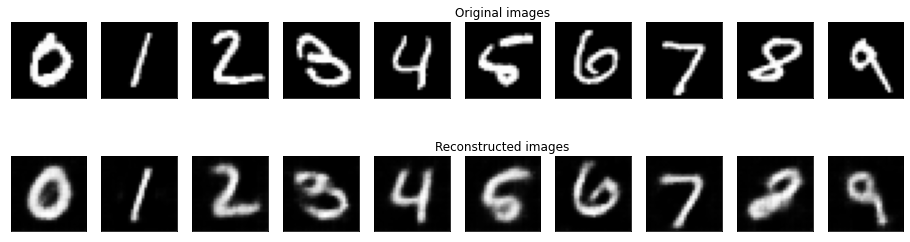

	 partial train loss (single batch): 0.029575
	 partial train loss (single batch): 0.026788
	 partial train loss (single batch): 0.027264
	 partial train loss (single batch): 0.026580
	 partial train loss (single batch): 0.026808
	 partial train loss (single batch): 0.026430
	 partial train loss (single batch): 0.027373
	 partial train loss (single batch): 0.027373
	 partial train loss (single batch): 0.027198
	 partial train loss (single batch): 0.026671
	 partial train loss (single batch): 0.025628
	 partial train loss (single batch): 0.026304
	 partial train loss (single batch): 0.026912
	 partial train loss (single batch): 0.026577
	 partial train loss (single batch): 0.027552
	 partial train loss (single batch): 0.026448
	 partial train loss (single batch): 0.026346
	 partial train loss (single batch): 0.025566
	 partial train loss (single batch): 0.027266
	 partial train loss (single batch): 0.027115
	 partial train loss (single batch): 0.027184
	 partial train loss (single batch

	 partial train loss (single batch): 0.026357
	 partial train loss (single batch): 0.027567
	 partial train loss (single batch): 0.026207
	 partial train loss (single batch): 0.025565
	 partial train loss (single batch): 0.025983
	 partial train loss (single batch): 0.027140
	 partial train loss (single batch): 0.025720
	 partial train loss (single batch): 0.026836
	 partial train loss (single batch): 0.025192

 EPOCH 18/30 	 train loss 0.026297304779291153 	 val loss 0.026655741035938263


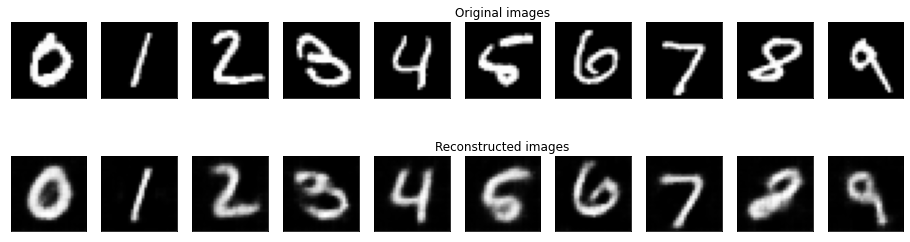

	 partial train loss (single batch): 0.029399
	 partial train loss (single batch): 0.026763
	 partial train loss (single batch): 0.027178
	 partial train loss (single batch): 0.026497
	 partial train loss (single batch): 0.026672
	 partial train loss (single batch): 0.026411
	 partial train loss (single batch): 0.027211
	 partial train loss (single batch): 0.027233
	 partial train loss (single batch): 0.027043
	 partial train loss (single batch): 0.026591
	 partial train loss (single batch): 0.025496
	 partial train loss (single batch): 0.026139
	 partial train loss (single batch): 0.026772
	 partial train loss (single batch): 0.026383
	 partial train loss (single batch): 0.027494
	 partial train loss (single batch): 0.026396
	 partial train loss (single batch): 0.026268
	 partial train loss (single batch): 0.025452
	 partial train loss (single batch): 0.027194
	 partial train loss (single batch): 0.026936
	 partial train loss (single batch): 0.027083
	 partial train loss (single batch

	 partial train loss (single batch): 0.027480
	 partial train loss (single batch): 0.026147
	 partial train loss (single batch): 0.025496
	 partial train loss (single batch): 0.025865
	 partial train loss (single batch): 0.027003
	 partial train loss (single batch): 0.025628
	 partial train loss (single batch): 0.026757
	 partial train loss (single batch): 0.025040

 EPOCH 19/30 	 train loss 0.026199115440249443 	 val loss 0.026551147922873497


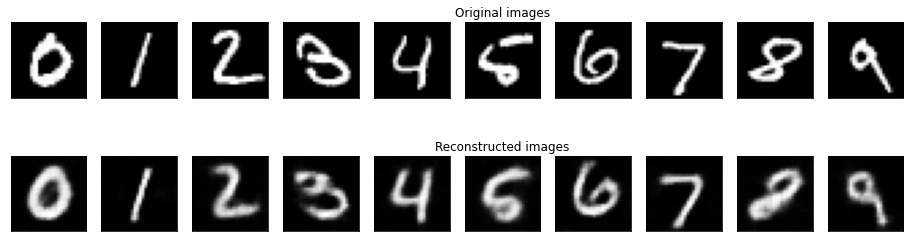

	 partial train loss (single batch): 0.029231
	 partial train loss (single batch): 0.026584
	 partial train loss (single batch): 0.027041
	 partial train loss (single batch): 0.026332
	 partial train loss (single batch): 0.026553
	 partial train loss (single batch): 0.026315
	 partial train loss (single batch): 0.027092
	 partial train loss (single batch): 0.027145
	 partial train loss (single batch): 0.026952
	 partial train loss (single batch): 0.026439
	 partial train loss (single batch): 0.025460
	 partial train loss (single batch): 0.026130
	 partial train loss (single batch): 0.026661
	 partial train loss (single batch): 0.026339
	 partial train loss (single batch): 0.027305
	 partial train loss (single batch): 0.026263
	 partial train loss (single batch): 0.026205
	 partial train loss (single batch): 0.025374
	 partial train loss (single batch): 0.027067
	 partial train loss (single batch): 0.026869
	 partial train loss (single batch): 0.027053
	 partial train loss (single batch

	 partial train loss (single batch): 0.026206
	 partial train loss (single batch): 0.027356
	 partial train loss (single batch): 0.026007
	 partial train loss (single batch): 0.025310
	 partial train loss (single batch): 0.025759
	 partial train loss (single batch): 0.026844
	 partial train loss (single batch): 0.025465
	 partial train loss (single batch): 0.026673
	 partial train loss (single batch): 0.024908

 EPOCH 20/30 	 train loss 0.026084640994668007 	 val loss 0.02641971781849861


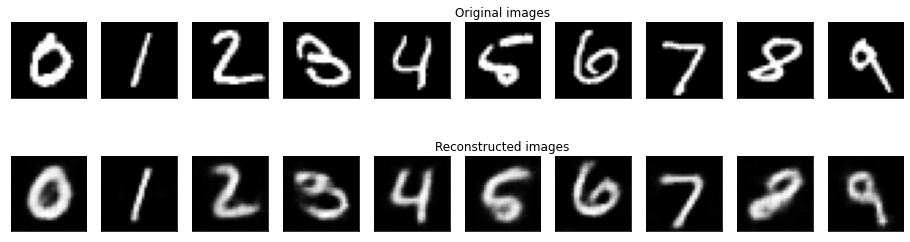

	 partial train loss (single batch): 0.029069
	 partial train loss (single batch): 0.026492
	 partial train loss (single batch): 0.026850
	 partial train loss (single batch): 0.026145
	 partial train loss (single batch): 0.026401
	 partial train loss (single batch): 0.026183
	 partial train loss (single batch): 0.026913
	 partial train loss (single batch): 0.027069
	 partial train loss (single batch): 0.026848
	 partial train loss (single batch): 0.026277
	 partial train loss (single batch): 0.025231
	 partial train loss (single batch): 0.026009
	 partial train loss (single batch): 0.026502
	 partial train loss (single batch): 0.026172
	 partial train loss (single batch): 0.027247
	 partial train loss (single batch): 0.026102
	 partial train loss (single batch): 0.026028
	 partial train loss (single batch): 0.025239
	 partial train loss (single batch): 0.026960
	 partial train loss (single batch): 0.026656
	 partial train loss (single batch): 0.026926
	 partial train loss (single batch

	 partial train loss (single batch): 0.026109
	 partial train loss (single batch): 0.027234
	 partial train loss (single batch): 0.025929
	 partial train loss (single batch): 0.025212
	 partial train loss (single batch): 0.025640
	 partial train loss (single batch): 0.026793
	 partial train loss (single batch): 0.025420
	 partial train loss (single batch): 0.026541
	 partial train loss (single batch): 0.024851

 EPOCH 21/30 	 train loss 0.025979509577155113 	 val loss 0.026332465931773186


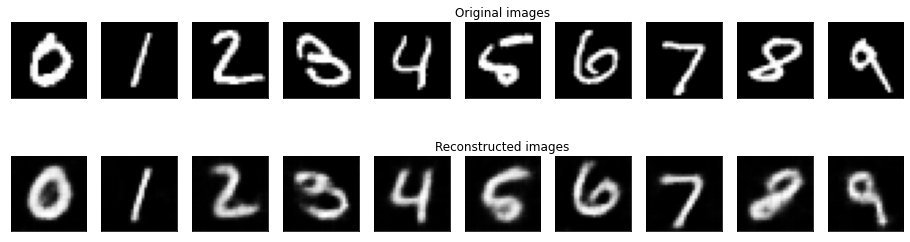

	 partial train loss (single batch): 0.028910
	 partial train loss (single batch): 0.026449
	 partial train loss (single batch): 0.026781
	 partial train loss (single batch): 0.026020
	 partial train loss (single batch): 0.026302
	 partial train loss (single batch): 0.026102
	 partial train loss (single batch): 0.026889
	 partial train loss (single batch): 0.026938
	 partial train loss (single batch): 0.026767
	 partial train loss (single batch): 0.026251
	 partial train loss (single batch): 0.025170
	 partial train loss (single batch): 0.025919
	 partial train loss (single batch): 0.026391
	 partial train loss (single batch): 0.026163
	 partial train loss (single batch): 0.027133
	 partial train loss (single batch): 0.026010
	 partial train loss (single batch): 0.025916
	 partial train loss (single batch): 0.025170
	 partial train loss (single batch): 0.026862
	 partial train loss (single batch): 0.026581
	 partial train loss (single batch): 0.026916
	 partial train loss (single batch

	 partial train loss (single batch): 0.027225
	 partial train loss (single batch): 0.025854
	 partial train loss (single batch): 0.025130
	 partial train loss (single batch): 0.025575
	 partial train loss (single batch): 0.026735
	 partial train loss (single batch): 0.025311
	 partial train loss (single batch): 0.026498
	 partial train loss (single batch): 0.024696

 EPOCH 22/30 	 train loss 0.025890659540891647 	 val loss 0.02625551074743271


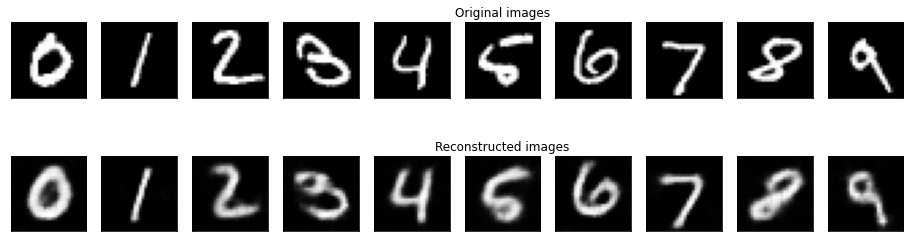

	 partial train loss (single batch): 0.028782
	 partial train loss (single batch): 0.026368
	 partial train loss (single batch): 0.026738
	 partial train loss (single batch): 0.025928
	 partial train loss (single batch): 0.026222
	 partial train loss (single batch): 0.025972
	 partial train loss (single batch): 0.026737
	 partial train loss (single batch): 0.026836
	 partial train loss (single batch): 0.026676
	 partial train loss (single batch): 0.026177
	 partial train loss (single batch): 0.025126
	 partial train loss (single batch): 0.025886
	 partial train loss (single batch): 0.026280
	 partial train loss (single batch): 0.026159
	 partial train loss (single batch): 0.027083
	 partial train loss (single batch): 0.026022
	 partial train loss (single batch): 0.025817
	 partial train loss (single batch): 0.025116
	 partial train loss (single batch): 0.026712
	 partial train loss (single batch): 0.026457
	 partial train loss (single batch): 0.026799
	 partial train loss (single batch

	 partial train loss (single batch): 0.027081
	 partial train loss (single batch): 0.025710
	 partial train loss (single batch): 0.025029
	 partial train loss (single batch): 0.025455
	 partial train loss (single batch): 0.026639
	 partial train loss (single batch): 0.025221
	 partial train loss (single batch): 0.026442
	 partial train loss (single batch): 0.024669

 EPOCH 23/30 	 train loss 0.02579442411661148 	 val loss 0.026210002601146698


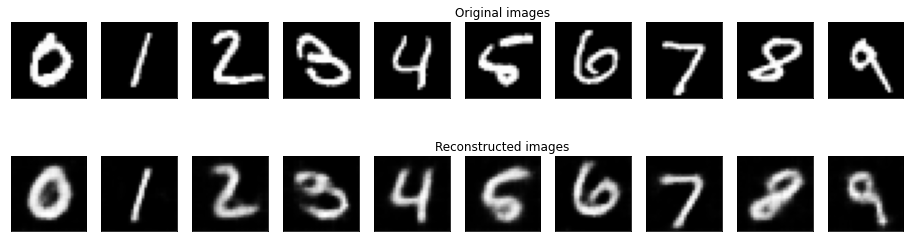

	 partial train loss (single batch): 0.028679
	 partial train loss (single batch): 0.026347
	 partial train loss (single batch): 0.026654
	 partial train loss (single batch): 0.025810
	 partial train loss (single batch): 0.026155
	 partial train loss (single batch): 0.025890
	 partial train loss (single batch): 0.026647
	 partial train loss (single batch): 0.026770
	 partial train loss (single batch): 0.026637
	 partial train loss (single batch): 0.026073
	 partial train loss (single batch): 0.024956
	 partial train loss (single batch): 0.025766
	 partial train loss (single batch): 0.026148
	 partial train loss (single batch): 0.026065
	 partial train loss (single batch): 0.027002
	 partial train loss (single batch): 0.025880
	 partial train loss (single batch): 0.025717
	 partial train loss (single batch): 0.025053
	 partial train loss (single batch): 0.026655
	 partial train loss (single batch): 0.026394
	 partial train loss (single batch): 0.026684
	 partial train loss (single batch

	 partial train loss (single batch): 0.025876
	 partial train loss (single batch): 0.027068
	 partial train loss (single batch): 0.025658
	 partial train loss (single batch): 0.024935
	 partial train loss (single batch): 0.025422
	 partial train loss (single batch): 0.026527
	 partial train loss (single batch): 0.025230
	 partial train loss (single batch): 0.026407
	 partial train loss (single batch): 0.024557

 EPOCH 24/30 	 train loss 0.025710903108119965 	 val loss 0.026173090562224388


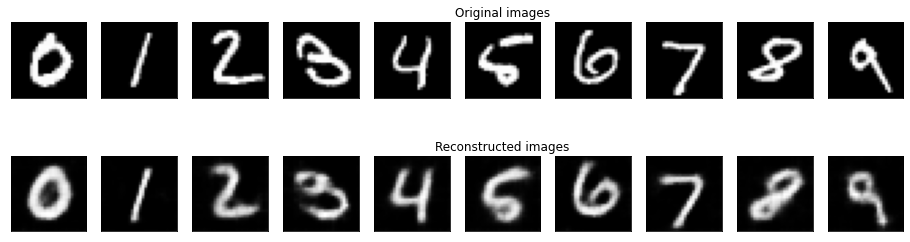

	 partial train loss (single batch): 0.028589
	 partial train loss (single batch): 0.026267
	 partial train loss (single batch): 0.026511
	 partial train loss (single batch): 0.025740
	 partial train loss (single batch): 0.026086
	 partial train loss (single batch): 0.025861
	 partial train loss (single batch): 0.026469
	 partial train loss (single batch): 0.026717
	 partial train loss (single batch): 0.026576
	 partial train loss (single batch): 0.025920
	 partial train loss (single batch): 0.024811
	 partial train loss (single batch): 0.025690
	 partial train loss (single batch): 0.026064
	 partial train loss (single batch): 0.025917
	 partial train loss (single batch): 0.026933
	 partial train loss (single batch): 0.025856
	 partial train loss (single batch): 0.025578
	 partial train loss (single batch): 0.024918
	 partial train loss (single batch): 0.026575
	 partial train loss (single batch): 0.026354
	 partial train loss (single batch): 0.026582
	 partial train loss (single batch

	 partial train loss (single batch): 0.025625
	 partial train loss (single batch): 0.024947
	 partial train loss (single batch): 0.025297
	 partial train loss (single batch): 0.026481
	 partial train loss (single batch): 0.025142
	 partial train loss (single batch): 0.026294
	 partial train loss (single batch): 0.024505

 EPOCH 25/30 	 train loss 0.025629563257098198 	 val loss 0.026166433468461037


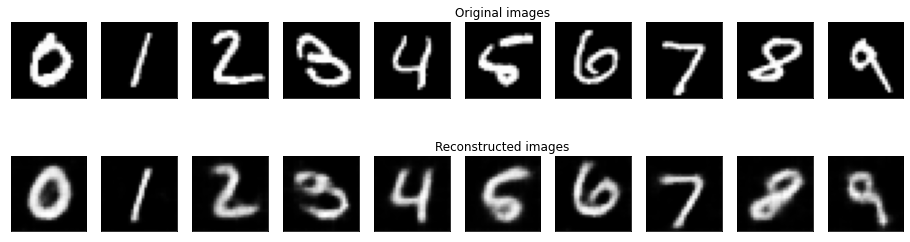

	 partial train loss (single batch): 0.028452
	 partial train loss (single batch): 0.026186
	 partial train loss (single batch): 0.026497
	 partial train loss (single batch): 0.025687
	 partial train loss (single batch): 0.025997
	 partial train loss (single batch): 0.025748
	 partial train loss (single batch): 0.026348
	 partial train loss (single batch): 0.026615
	 partial train loss (single batch): 0.026586
	 partial train loss (single batch): 0.025922
	 partial train loss (single batch): 0.024769
	 partial train loss (single batch): 0.025669
	 partial train loss (single batch): 0.026089
	 partial train loss (single batch): 0.025903
	 partial train loss (single batch): 0.026930
	 partial train loss (single batch): 0.025741
	 partial train loss (single batch): 0.025587
	 partial train loss (single batch): 0.024903
	 partial train loss (single batch): 0.026517
	 partial train loss (single batch): 0.026353
	 partial train loss (single batch): 0.026464
	 partial train loss (single batch

	 partial train loss (single batch): 0.025675
	 partial train loss (single batch): 0.026887
	 partial train loss (single batch): 0.025592
	 partial train loss (single batch): 0.024746
	 partial train loss (single batch): 0.025255
	 partial train loss (single batch): 0.026416
	 partial train loss (single batch): 0.025055
	 partial train loss (single batch): 0.026178
	 partial train loss (single batch): 0.024403

 EPOCH 26/30 	 train loss 0.02556671015918255 	 val loss 0.026082322001457214


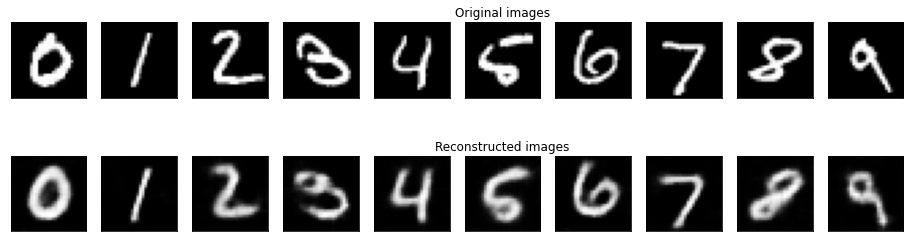

	 partial train loss (single batch): 0.028285
	 partial train loss (single batch): 0.026106
	 partial train loss (single batch): 0.026354
	 partial train loss (single batch): 0.025579
	 partial train loss (single batch): 0.025954
	 partial train loss (single batch): 0.025611
	 partial train loss (single batch): 0.026278
	 partial train loss (single batch): 0.026490
	 partial train loss (single batch): 0.026489
	 partial train loss (single batch): 0.025806
	 partial train loss (single batch): 0.024708
	 partial train loss (single batch): 0.025572
	 partial train loss (single batch): 0.026003
	 partial train loss (single batch): 0.025866
	 partial train loss (single batch): 0.026832
	 partial train loss (single batch): 0.025673
	 partial train loss (single batch): 0.025465
	 partial train loss (single batch): 0.024731
	 partial train loss (single batch): 0.026440
	 partial train loss (single batch): 0.026267
	 partial train loss (single batch): 0.026392
	 partial train loss (single batch

	 partial train loss (single batch): 0.025548
	 partial train loss (single batch): 0.024819
	 partial train loss (single batch): 0.025296
	 partial train loss (single batch): 0.026456
	 partial train loss (single batch): 0.025042
	 partial train loss (single batch): 0.026166
	 partial train loss (single batch): 0.024319

 EPOCH 27/30 	 train loss 0.02550649084150791 	 val loss 0.026101741939783096


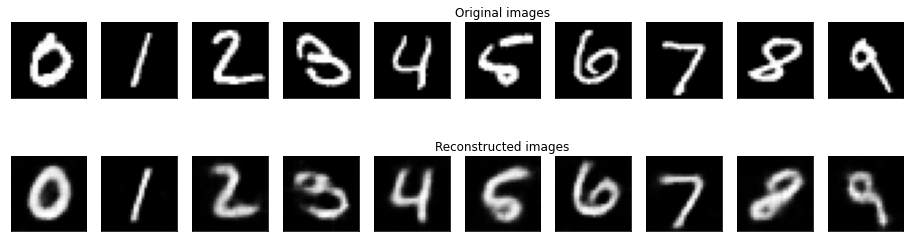

	 partial train loss (single batch): 0.028200
	 partial train loss (single batch): 0.026088
	 partial train loss (single batch): 0.026262
	 partial train loss (single batch): 0.025541
	 partial train loss (single batch): 0.025862
	 partial train loss (single batch): 0.025584
	 partial train loss (single batch): 0.026291
	 partial train loss (single batch): 0.026441
	 partial train loss (single batch): 0.026490
	 partial train loss (single batch): 0.025779
	 partial train loss (single batch): 0.024647
	 partial train loss (single batch): 0.025477
	 partial train loss (single batch): 0.025970
	 partial train loss (single batch): 0.025892
	 partial train loss (single batch): 0.026724
	 partial train loss (single batch): 0.025580
	 partial train loss (single batch): 0.025394
	 partial train loss (single batch): 0.024652
	 partial train loss (single batch): 0.026351
	 partial train loss (single batch): 0.026154
	 partial train loss (single batch): 0.026359
	 partial train loss (single batch

	 partial train loss (single batch): 0.026987
	 partial train loss (single batch): 0.025501
	 partial train loss (single batch): 0.024708
	 partial train loss (single batch): 0.025254
	 partial train loss (single batch): 0.026356
	 partial train loss (single batch): 0.024958
	 partial train loss (single batch): 0.026060
	 partial train loss (single batch): 0.024182

 EPOCH 28/30 	 train loss 0.02544548176229 	 val loss 0.02605568803846836


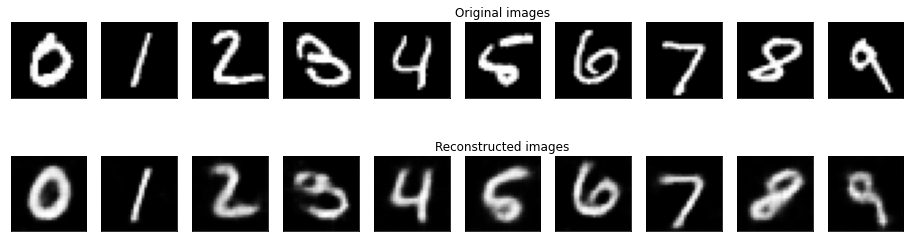

	 partial train loss (single batch): 0.028152
	 partial train loss (single batch): 0.026015
	 partial train loss (single batch): 0.026177
	 partial train loss (single batch): 0.025438
	 partial train loss (single batch): 0.025811
	 partial train loss (single batch): 0.025541
	 partial train loss (single batch): 0.026142
	 partial train loss (single batch): 0.026392
	 partial train loss (single batch): 0.026403
	 partial train loss (single batch): 0.025728
	 partial train loss (single batch): 0.024546
	 partial train loss (single batch): 0.025387
	 partial train loss (single batch): 0.025899
	 partial train loss (single batch): 0.025807
	 partial train loss (single batch): 0.026637
	 partial train loss (single batch): 0.025487
	 partial train loss (single batch): 0.025241
	 partial train loss (single batch): 0.024549
	 partial train loss (single batch): 0.026330
	 partial train loss (single batch): 0.026096
	 partial train loss (single batch): 0.026198
	 partial train loss (single batch

	 partial train loss (single batch): 0.025534
	 partial train loss (single batch): 0.026887
	 partial train loss (single batch): 0.025445
	 partial train loss (single batch): 0.024754
	 partial train loss (single batch): 0.025213
	 partial train loss (single batch): 0.026316
	 partial train loss (single batch): 0.024958
	 partial train loss (single batch): 0.026034
	 partial train loss (single batch): 0.024103

 EPOCH 29/30 	 train loss 0.025386113673448563 	 val loss 0.02602149173617363


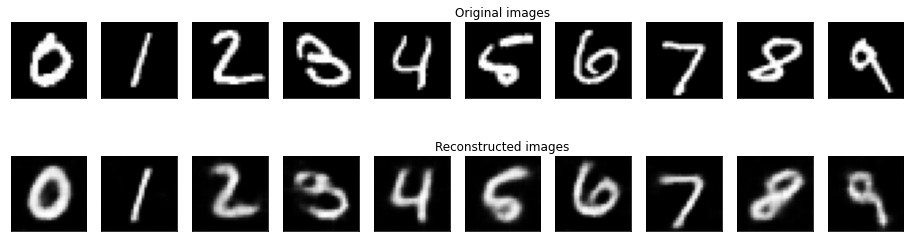

	 partial train loss (single batch): 0.028113
	 partial train loss (single batch): 0.025938
	 partial train loss (single batch): 0.026112
	 partial train loss (single batch): 0.025421
	 partial train loss (single batch): 0.025787
	 partial train loss (single batch): 0.025475
	 partial train loss (single batch): 0.026105
	 partial train loss (single batch): 0.026309
	 partial train loss (single batch): 0.026424
	 partial train loss (single batch): 0.025652
	 partial train loss (single batch): 0.024494
	 partial train loss (single batch): 0.025342
	 partial train loss (single batch): 0.025808
	 partial train loss (single batch): 0.025748
	 partial train loss (single batch): 0.026582
	 partial train loss (single batch): 0.025415
	 partial train loss (single batch): 0.025191
	 partial train loss (single batch): 0.024539
	 partial train loss (single batch): 0.026244
	 partial train loss (single batch): 0.026126
	 partial train loss (single batch): 0.026156
	 partial train loss (single batch

	 partial train loss (single batch): 0.025507
	 partial train loss (single batch): 0.026838
	 partial train loss (single batch): 0.025454
	 partial train loss (single batch): 0.024664
	 partial train loss (single batch): 0.025138
	 partial train loss (single batch): 0.026254
	 partial train loss (single batch): 0.024848
	 partial train loss (single batch): 0.025977
	 partial train loss (single batch): 0.024033

 EPOCH 30/30 	 train loss 0.025336138904094696 	 val loss 0.025985276326537132


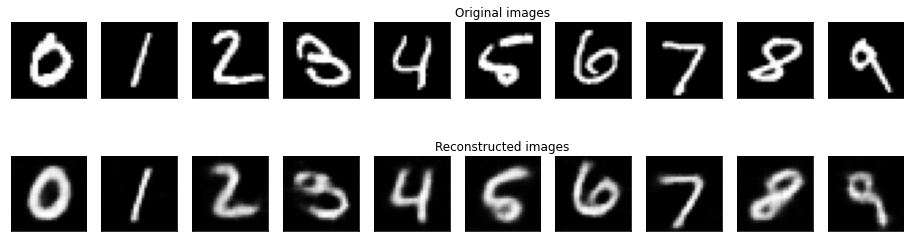

In [9]:
num_epochs = 30
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)

In [10]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.025985276326537132

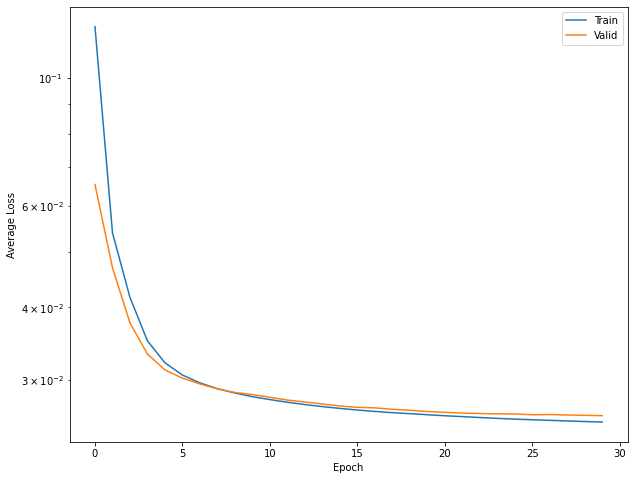

In [11]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

# 4. Generate samples

tensor([-0.1476,  0.2032,  0.1575,  0.0107])
tensor([0.6920, 0.6694, 0.6806, 0.4888])


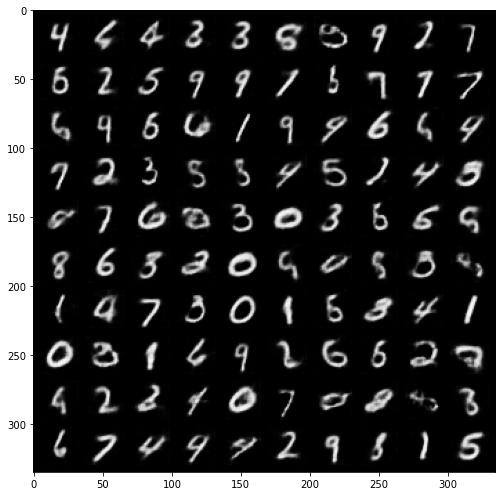

In [12]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = iter(test_loader).next()
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()

# 5. Latent space

In [15]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:07<00:00, 1409.24it/s]


Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0           -1.656823         0.372837         0.508301        -0.806971   
1            0.189592         0.440215         1.269414        -0.092299   
2           -0.903219         1.500665         0.843881         0.932073   
3            0.746463        -0.614458        -0.593416         0.172508   
4           -0.434570         0.780139        -1.158603        -0.354520   
...               ...              ...              ...              ...   
9995        -0.360497        -0.174536         0.819450        -0.264421   
9996         0.667294        -0.097909         0.898605        -0.111523   
9997        -1.089214         0.814646        -0.725929         0.284497   
9998        -0.139974        -0.297367         0.171742         0.776772   
9999         0.305514        -0.000973        -0.648798         0.229371   

      label  
0         7  
1         2  
2         1  
3         0  
4         4  
...     ...  
9995      2  
9996      3  
9997      4  
9998      5  
9999      6  

[10000 rows x 5 columns]

In [19]:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)


In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

# 6. Classificator on latent space

In [22]:
encoded_samples.shape

(10000, 5)

In [24]:
X = encoded_samples[['Enc. Variable 0','Enc. Variable 1', 'Enc. Variable 2','Enc. Variable 3']]
y = encoded_samples['label']

In [31]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [32]:
model_clf = tree.DecisionTreeClassifier()
model_clf = model_clf.fit(X_train, y_train)
y_pred = model_clf.predict(X_test)

In [33]:
accuracy_score(y_test, y_pred)

0.8896969696969697

# 7. Conclusions

1.Convolutional autoencoder was build with using MNIST dataset in this work. Both encoder and decoder are using 3 convolutional layers with 2 linear layers
2.After getting latent space from the autoencoder, this data was used to get classification model predicting a number between 0 and 9. Accuracy score for this model equals 0.8896